In [54]:
from datetime import datetime

import pandas as pd
import numpy as np

import codecs, json 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb

import scipy
import time

import scipy_interpolation_functions as scipy_int

In [33]:
def read_data():
    df = pd.DataFrame([])
    for i in range(7):
        with open('/Users/calmaleh/Desktop/school/project_course/jeppesen/ac_poor_' + str(i+1) +'.bsad') as json_file:
            json_data = json.load(json_file)

        frames = []
        for j in range(len(json_data['tables'])):
            temp_df = pd.DataFrame(np.array(json_data['tables'][j]['table'])[:,:], 
                                   columns = json_data['tables'][j]['header']['variables'][:])
            temp_df['state'] = json_data['tables'][j]['header']['flightphase']
            if temp_df['state'][0] == 'cruise':
                frames.append(temp_df)

        temp_df = pd.concat(frames,ignore_index=True)
        temp_df = temp_df[['DISA','ALTITUDE','MASS','TAS','FUELFLOW']]
        
        df = pd.concat([df,temp_df])

    scaler = MinMaxScaler()
    df = scaler.fit_transform(df)

    df = pd.DataFrame(df, columns = ['DISA','ALTITUDE','MASS','TAS','FUELFLOW'])

    df['MACH'] = df['TAS']
    X = df.drop(['FUELFLOW','TAS'], axis=1)
    y = df.FUELFLOW

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01)
    return X_train, X_test, y_train, y_test

In [34]:
X_train, X_test, y_train, y_test = read_data()
X_train

,DISA,ALTITUDE,MASS,MACH
7360,0.714286,0.960784,0.054636,0.545932
2075,0.428571,0.803922,0.342163,0.727034
5086,0.142857,0.196078,0.783664,0.368241
3422,0.142857,0.686275,0.331126,0.679790
688,0.142857,0.764706,0.187638,0.845144
...,...,...,...,...
2235,0.714286,0.196078,0.110375,0.442257
3491,0.714286,0.607843,0.154525,0.753281
3850,0.714286,0.686275,0.331126,0.860892
4600,0.428571,0.764706,0.562914,0.858268


0.3112827249987618
0.18319990757790436


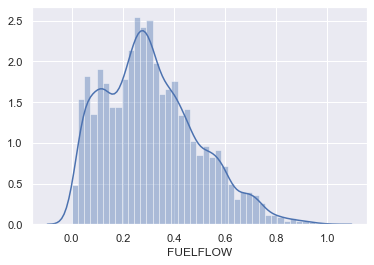

In [66]:
print(np.mean(y_train))
print(np.std(y_train))
sns.distplot(y_train)

In [35]:
##################################################################

#Pandas linear

##################################################################

In [44]:
mse_array = []
time_array = []

for k in range(10):
    X_train, X_test, y_train, y_test = read_data()
    start = time.time()
    output = np.zeros((len(y_test), 2))

    for i in range(len(X_test)):
        test = X_test.iloc[i]
        y_check = y_test.iloc[i]

        X_train_1 = X_train.copy()
        X_train_1['distance'] = X_train_1.sub(test).pow(2).sum(1).pow(0.5) # maybe cutoff based on input

        end = 16
        z = X_train_1.sort_values('distance').iloc[0:end]
        z = z.drop(['distance'],axis = 1)
        z = z.reset_index()
        z.columns = ['index_', 'DISA', 'ALTITUDE', 'MASS', 'MACH']
        y_train.columns = ['index_', 'FUELFLOW']
        z = z.join(y_train, on = 'index_', how = 'left')
        z = z.drop(['index_'], axis=1)

        z_inter = z[0:1].append(test)
        z_inter = z_inter.append(z[2:end])

        y_inter = z_inter.interpolate(method = 'linear')['FUELFLOW']

        output[i,0] = y_check
        output[i,1] = y_inter.iloc[1]

    end = time.time()

    #print('Time: ',end - start)
    #print('MSE: ', mean_squared_error(output[0], output[1]))
    mse_array.append(mean_squared_error(output[0], output[1]))
    time_array.append(end - start)

    #plt.scatter(np.arange(0,len(output)),output[:,0]-output[:,1])
    #plt.title('Residual plot (y interpolated - y actual)')
    #plt.show()

    #X_test['y_interpolate'] = output[:,1]
    #X_test['y_actual'] = output[:,0]

    #plt.subplot(1,2,1)
    #sns.scatterplot(x='ALTITUDE', y='y_actual', data = X_test, color ='b')
    #plt.subplot(1,2,2)
    #sns.scatterplot(x='ALTITUDE', y= 'y_interpolate', data = X_test, color ='r')
    #plt.tight_layout()

print(np.mean(mse_array))
print('\n')
print(np.std(mse_array))
print('\n')
print(time_array)


0.07199623976729888


0.08572497592279267


[1.2016379833221436, 1.263443946838379, 1.1514348983764648, 1.1504361629486084, 1.157109022140503, 1.1585278511047363, 1.1634490489959717, 1.1618750095367432, 1.1820039749145508, 1.1568708419799805]


In [37]:
##################################################################

#Scipy linear

##################################################################

In [50]:
mse_array = []
time_array = []

for k in range(10):
    X_train, X_test, y_train, y_test = read_data()
    X_train_scipy = X_train.copy()
    X_train_scipy['FUELFLOW'] = y_train

    #X_test = X_test.drop(['y_interpolate', 'y_actual'], axis=1)

    start = time.time()
    output = np.zeros((len(y_test), 2))

    for i in range(len(X_test)):
        test = X_test.iloc[i]
        y_check = y_test.iloc[i]

        y_inter = scipy_int.scipy_interpolation_linear(X_train_scipy, test)

        if np.isnan(y_inter)== True : #Extrapolate
            y = X_train_scipy.FUELFLOW
            X = X_train_scipy.drop(['FUELFLOW'], axis=1)
            point,value = scipy_int.closest_points(X,y,test,1)
            y_inter = value

        output[i,0] = y_check
        output[i,1] = y_inter[0]

    end = time.time()

    #print('Time: ',end - start)
    #print('MSE: ', mean_squared_error(output[0], output[1]))
    mse_array.append(mean_squared_error(output[0], output[1]))
    time_array.append(end - start)

    #plt.scatter(np.arange(0,len(output)),output[:,0]-output[:,1])
    #plt.title('Residual plot (y interpolated - y actual)')
    #plt.show()

    #X_test['y_interpolate'] = output[:,1]
    #X_test['y_actual'] = output[:,0]

    #plt.subplot(1,2,1)
    #sns.scatterplot(x='ALTITUDE', y='y_actual', data = X_test, color ='b')
    #plt.subplot(1,2,2)
    #sns.scatterplot(x='ALTITUDE', y= 'y_interpolate', data = X_test, color ='r')
    #plt.tight_layout()

print(np.mean(mse_array))
print('\n')
print(np.std(mse_array))
print('\n')
print(time_array)



0.05159677766376897


0.05847307211123779


[87.32199096679688, 84.523432970047, 85.10165190696716, 82.50423312187195, 81.52580308914185, 85.18181014060974, 77.52764105796814, 89.67856478691101, 87.2355592250824, 84.01013398170471]


In [55]:
##################################################################

#Scipy nearest

##################################################################

In [53]:
mse_array = []
time_array = []

for k in range(10):
    X_train, X_test, y_train, y_test = read_data()
    X_train_scipy = X_train.copy()
    X_train_scipy['FUELFLOW'] = y_train

    #X_test = X_test.drop(['y_interpolate', 'y_actual'], axis=1)

    start = time.time()

    output = np.zeros((len(y_test), 2))

    for i in range(len(X_test)):
        test = X_test.iloc[i]
        y_check = y_test.iloc[i]

        y_inter = scipy_int.scipy_interpolation_nearest(X_train_scipy, test)

        output[i,0] = y_check
        output[i,1] = y_inter.iloc[0]

    end = time.time()

    #print('Time: ',end - start)
    #print('MSE: ', mean_squared_error(output[0], output[1]))
    mse_array.append(mean_squared_error(output[0], output[1]))
    time_array.append(end - start)

    #plt.scatter(np.arange(0,len(output)),output[:,0]-output[:,1])
    #plt.title('Residual plot (y interpolated - y actual)')
    #plt.show()

    #X_test['y_interpolate'] = output[:,1]
    #X_test['y_actual'] = output[:,0]

    #plt.subplot(1,2,1)
    #sns.scatterplot(x='ALTITUDE', y='y_actual', data = X_test, color ='b')
    #plt.subplot(1,2,2)
    #sns.scatterplot(x='ALTITUDE', y= 'y_interpolate', data = X_test, color ='r')
    #plt.tight_layout()

print(np.mean(mse_array))
print('\n')
print(np.std(mse_array))
print('\n')
print(time_array)



0.026548820029117577


0.03851065035762812


[2.7167470455169678, 2.3336446285247803, 2.732123851776123, 1.9301950931549072, 1.790309190750122, 2.5069081783294678, 1.4912047386169434, 1.9890930652618408, 1.7756268978118896, 1.7081470489501953]


In [64]:
mse_array = []
time_array = []

for k in range(10):
    X_train, X_test, y_train, y_test = read_data()
    X_train_scipy = X_train.copy()
    X_train_scipy['FUELFLOW'] = y_train

    #X_test = X_test.drop(['y_interpolate', 'y_actual'], axis=1)

    start = time.time()

    output = np.zeros((len(y_test), 2))
    
    xgb_ = xgb.XGBRegressor().fit(X_train_scipy.drop(['FUELFLOW'], axis=1),X_train_scipy.FUELFLOW)

    for i in range(len(X_test)):
        test = X_test.iloc[i]
        y_check = y_test.iloc[i]

        y_inter = xgb_.predict(test)

        output[i,0] = y_check
        output[i,1] = y_inter.iloc[0]

    end = time.time()

    #print('Time: ',end - start)
    #print('MSE: ', mean_squared_error(output[0], output[1]))
    mse_array.append(mean_squared_error(output[0], output[1]))
    time_array.append(end - start)

    #plt.scatter(np.arange(0,len(output)),output[:,0]-output[:,1])
    #plt.title('Residual plot (y interpolated - y actual)')
    #plt.show()

    #X_test['y_interpolate'] = output[:,1]
    #X_test['y_actual'] = output[:,0]

    #plt.subplot(1,2,1)
    #sns.scatterplot(x='ALTITUDE', y='y_actual', data = X_test, color ='b')
    #plt.subplot(1,2,2)
    #sns.scatterplot(x='ALTITUDE', y= 'y_interpolate', data = X_test, color ='r')
    #plt.tight_layout()

print(np.mean(mse_array))
print('\n')
print(np.std(mse_array))
print('\n')
print(time_array)




/anaconda3/envs/py36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/py36/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:48:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


ValueError: feature_names mismatch: ['DISA', 'ALTITUDE', 'MASS', 'MACH'] ['f0', 'f1', 'f2', 'f3']
expected MASS, DISA, ALTITUDE, MACH in input data
training data did not have the following fields: f1, f0, f2, f3